In [296]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
import numpy as np

# this allows plots to appear directly in the notebook
%matplotlib inline

# read data into a DataFrame
data = pd.read_csv('SF Listings - Ex Zillow.csv', index_col=0)
del data['Term']
del data['URL']
del data['Rented']
data['Date'] = pd.to_datetime(data['Date'])

# create year dummy variables (because date isn't very intuitive variable)
data["Year"] = pd.DatetimeIndex(data["Date"]).to_period('Y')

# create dummy variables using get_dummies, then exclude the first dummy column
year_dummies = pd.get_dummies(data.Year, prefix='Year').iloc[:, :-1]

# print out baseline neighborhood
base_area = pd.get_dummies(data.Neighborhood, prefix='Neighborhood').iloc[:, 0:1].columns[0]
print('Base neighborhood: %s' % base_area)

# create dummy variables using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(data.Neighborhood, prefix='Neighborhood').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
data = pd.concat([data, area_dummies, year_dummies], axis=1)

data.head()

Base neighborhood: Neighborhood_Alamo Square


,Neighborhood,Bedrooms,Bathrooms,Price,Sqft,Date,Source,Year,Neighborhood_Bayview,Neighborhood_Berkeley,...,Neighborhood_Visitacion Valley,Neighborhood_Walnut Creek,Neighborhood_West Oakland,Neighborhood_Western Addition,Neighborhood_Westwood Park,Neighborhood_Yerba Buena,Year_2011,Year_2012,Year_2013,Year_2014
Address,,,,,,,,,,,,,,,,,,,,,
539 Octavia Street #9,Hayes Valley,0,1,1500,180,2015-03-18,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,0
539 Octavia Street #11,Hayes Valley,0,1,1600,200,2015-03-30,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,0
539 Octavia Street #14,Hayes Valley,0,1,1850,221,2015-05-14,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,0
539 Octavia Street #12,Hayes Valley,0,1,1800,240,2015-04-16,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,0
539 Octavia Street #13,Hayes Valley,0,1,1995,280,2015-02-01,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,0


In [297]:
# filter out any outliers, defined as rent >$10k or >2,500 sq ft

data = data[(data.Sqft <= 2500) & (data.Price <= 8000) & (data.Bedrooms <= 4) & (data.Bathrooms <= 3)]

In [298]:
# FACTORING BY YEAR AND NEIGHBORHOOD
# Thesis: Neighborhoods influence valuations as a multiplier, rather than a constant.
# a square foot in SOMA is worth more than a square foot in Portrero by X%
# New model will look like this: 
#      Price = B_1 x (SOMA Coeff * Year Coeff * Sqft) + intercept
#      $3,900 = B_1 x (1.20% * 1.15% * 2,023 sqft) + intercept
# where B_1 represents the price per square foot in base year and base neighborhood
# I will ignore intercepts for now FIXME
# calculate the coefficients for the following matrix and save them for later regressions
#                  SOMA    Mission    Portrero    Intercept
#  Price/SQFT      $1.23    $0.59       $0.88        $_.__

# create Price per square foot

price_per_foot = data.Price / data.Sqft
price_per_foot.name = 'price_per_foot'
data = pd.concat([data, price_per_foot], axis=1)

data.head()


,Neighborhood,Bedrooms,Bathrooms,Price,Sqft,Date,Source,Year,Neighborhood_Bayview,Neighborhood_Berkeley,...,Neighborhood_Walnut Creek,Neighborhood_West Oakland,Neighborhood_Western Addition,Neighborhood_Westwood Park,Neighborhood_Yerba Buena,Year_2011,Year_2012,Year_2013,Year_2014,price_per_foot
Address,,,,,,,,,,,,,,,,,,,,,
539 Octavia Street #9,Hayes Valley,0,1,1500,180,2015-03-18,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,8.333333
539 Octavia Street #11,Hayes Valley,0,1,1600,200,2015-03-30,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,8.000000
539 Octavia Street #14,Hayes Valley,0,1,1850,221,2015-05-14,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,8.371041
539 Octavia Street #12,Hayes Valley,0,1,1800,240,2015-04-16,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,7.500000
539 Octavia Street #13,Hayes Valley,0,1,1995,280,2015-02-01,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,0,0,7.125000


In [299]:
feature_cols = area_dummies.columns

X = data[feature_cols]
y = data.price_per_foot

# instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((lm.predict(X) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(X, y))

# print raw results
print("Intercept: %.2f" % lm.intercept_)

zip(feature_cols,lm.coef_)

Residual sum of squares: 0.60
Variance score: 0.51
Intercept: 3.29


[('Neighborhood_Bayview', 0.22919224160121199),
 ('Neighborhood_Berkeley', -0.46804511278195582),
 ('Neighborhood_Bernal Heights', 0.16135688057351771),
 ('Neighborhood_Buena Vista', 0.40915645277574719),
 ('Neighborhood_Candlestick Point', -0.367436740665263),
 ('Neighborhood_Central Richmond', -0.42195231668915678),
 ('Neighborhood_Central Waterfront', 0.88952843060745468),
 ('Neighborhood_Clarendon Heights', -2.2624743754446149e-15),
 ('Neighborhood_Cole Valley-Parnassus Heights', 1.0182186234817743),
 ('Neighborhood_Diamond Heights', -0.48096304591265182),
 ('Neighborhood_Dogpatch', -0.031787007783011578),
 ('Neighborhood_Downtown', 1.1549707602339019),
 ('Neighborhood_Downtown Oakland', -1.3728070175438778),
 ('Neighborhood_Downtown San Francisco', -0.23708338586672215),
 ('Neighborhood_Duboce Triangle', 1.2105263157894761),
 ('Neighborhood_Emeryville', -0.59662958948507128),
 ('Neighborhood_Eureka Valley', 0.85338345864660869),
 ('Neighborhood_Eureka Valley-Dolores Heights', 0.97

In [300]:

full_price = [lm.intercept_] * len(lm.coef_)
full_price += lm.coef_

area_price_per_foot = dict(zip(feature_cols,full_price))
area_price_per_foot[base_area] = lm.intercept_

print area_price_per_foot


# calculate the coefficients for the following matrix:
#               2011    2012    2013    2014    2015
#  SQFT

{'Neighborhood_Buena Vista': 3.6986301369862762, 'Neighborhood_Nob Hill': 4.7375104345206491, 'Neighborhood_Lower Pacific Heights': 4.3617025461870131, 'Neighborhood_Clarendon Heights': 3.2894736842105265, 'Neighborhood_Alamo Square': 3.2894736842105288, 'Neighborhood_Golden Gate Heights': 3.8333333333333259, 'Neighborhood_Outer Richmond': 3.7499999999999991, 'Neighborhood_Bernal Heights': 3.4508305647840465, 'Neighborhood_Westwood Park': 2.4197002141327628, 'Neighborhood_Rincon Hill': 4.5340191230428202, 'Neighborhood_Oakland': 2.7288828376313181, 'Neighborhood_Russian Hill': 3.2894736842105283, 'Neighborhood_South Beach': 4.3691864365018578, 'Neighborhood_Eureka Valley': 4.142857142857137, 'Neighborhood_Financial District': 4.367816091954027, 'Neighborhood_Downtown San Francisco': 3.0523902983438065, 'Neighborhood_North Beach': 3.5763888888888888, 'Neighborhood_Central Richmond': 2.867521367521372, 'Neighborhood_Mission Dolores': 5.2916666666666705, 'Neighborhood_Excelsior': 3.222222

In [301]:
# calculate the multipliers for each neighborhood relative to base area
# SOMA_mult = SOMA_per_foot / Base_per_foot

area_mults = [lm.intercept_] * len(lm.coef_)
area_mults = full_price / area_mults - [1]*len(lm.coef_)

zip(feature_cols, area_mults)



[('Neighborhood_Bayview', 0.069674441446768265),
 ('Neighborhood_Berkeley', -0.14228571428571446),
 ('Neighborhood_Bernal Heights', 0.049052491694349332),
 ('Neighborhood_Buena Vista', 0.12438356164382713),
 ('Neighborhood_Candlestick Point', -0.11170076916223992),
 ('Neighborhood_Central Richmond', -0.12827350427350359),
 ('Neighborhood_Central Waterfront', 0.27041664290466594),
 ('Neighborhood_Clarendon Heights', -6.6613381477509392e-16),
 ('Neighborhood_Cole Valley-Parnassus Heights', 0.3095384615384591),
 ('Neighborhood_Diamond Heights', -0.14621276595744603),
 ('Neighborhood_Dogpatch', -0.0096632503660355473),
 ('Neighborhood_Downtown', 0.35111111111110582),
 ('Neighborhood_Downtown Oakland', -0.41733333333333855),
 ('Neighborhood_Downtown San Francisco', -0.072073349303483525),
 ('Neighborhood_Duboce Triangle', 0.36800000000000055),
 ('Neighborhood_Emeryville', -0.18137539520346146),
 ('Neighborhood_Eureka Valley', 0.25942857142856868),
 ('Neighborhood_Eureka Valley-Dolores Heigh

In [302]:
# calculate the adjusted Sqft (Sqft * Area_mult) for the dataset and add it as a new column to data

# for each property, multiplier is sum of array [area_dummies] x [area_mults]

t = data[area_dummies.columns] * area_mults
t = t.T.sum()

t.name = 'area_multiplier'
t = t + 1
data = pd.concat([data, t], axis=1)

adj_sqft = data.Sqft * t
adj_sqft.name = 'area_adj_sqft'
data = pd.concat([data, adj_sqft], axis=1)

data.head()



,Neighborhood,Bedrooms,Bathrooms,Price,Sqft,Date,Source,Year,Neighborhood_Bayview,Neighborhood_Berkeley,...,Neighborhood_Western Addition,Neighborhood_Westwood Park,Neighborhood_Yerba Buena,Year_2011,Year_2012,Year_2013,Year_2014,price_per_foot,area_multiplier,area_adj_sqft
Address,,,,,,,,,,,,,,,,,,,,,
539 Octavia Street #9,Hayes Valley,0,1,1500,180,2015-03-18,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,8.333333,1.944004,349.920732
539 Octavia Street #11,Hayes Valley,0,1,1600,200,2015-03-30,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,8.000000,1.944004,388.800813
539 Octavia Street #14,Hayes Valley,0,1,1850,221,2015-05-14,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,8.371041,1.944004,429.624899
539 Octavia Street #12,Hayes Valley,0,1,1800,240,2015-04-16,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,7.500000,1.944004,466.560976
539 Octavia Street #13,Hayes Valley,0,1,1995,280,2015-02-01,Climb SF,2015,0,0,...,0,0,0,0,0,0,0,7.125000,1.944004,544.321139


Intercept: 1142.55
Residual sum of squares: 507164.94
Variance score: 0.73


[]

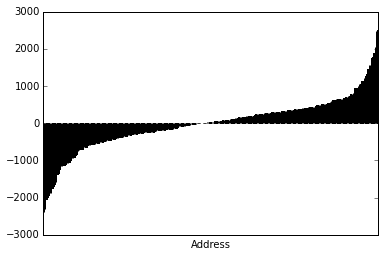

In [303]:
# run the regression based on area_adj_sqft rather than sqft

# create X and y
feature_cols = [data.area_adj_sqft.name]

X = data[feature_cols]
y = data.Price

# instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
print("Intercept: %.2f" % lm.intercept_)

# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((lm.predict(X) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(X, y))
zip(feature_cols, lm.coef_)

# calculate predictions for the data set and plot errors
predictions = lm.predict(X)
errors = predictions-y
errors.name = 'Error'

# visualize the relationship between the features and the response using scatterplots
errors.sort()
errors.plot(kind='bar').get_xaxis().set_ticks([])

In [304]:
feature_cols = year_dummies.columns

X = data[feature_cols]
y = data.price_per_foot

# instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((lm.predict(X) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(X, y))

# print raw results
print lm.intercept_

zip(feature_cols,lm.coef_)

Residual sum of squares: 1.16
Variance score: 0.06
4.43106702515


[(u'Year_2011', -0.26050619124350716),
 (u'Year_2012', -1.0047722044318308),
 (u'Year_2013', -0.68048935241674591),
 (u'Year_2014', -0.47727887796110385)]

In [305]:
full_price = [lm.intercept_] * len(lm.coef_)
full_price += lm.coef_

year_price_per_foot = dict(zip(feature_cols,full_price))
year_price_per_foot[base_area] = lm.intercept_

print year_price_per_foot

{u'Year_2012': 3.4262948207171355, u'Year_2013': 3.75057767273222, 'Neighborhood_Alamo Square': 4.4310670251489661, u'Year_2011': 4.1705608339054585, u'Year_2014': 3.9537881471878622}


In [306]:
# calculate the multipliers for each year relative to base year
# 2014_mult = 2014_per_foot / 2015_per_foot

year_mults = [lm.intercept_] * len(lm.coef_)
year_mults = full_price / year_mults - [1]*len(lm.coef_)

zip(feature_cols, year_mults)

[(u'Year_2011', -0.058790848742521495),
 (u'Year_2012', -0.22675626406216498),
 (u'Year_2013', -0.15357234466428971),
 (u'Year_2014', -0.10771195182836546)]

In [307]:
# calculate the adjusted Sqft (Sqft * Year_mult) for the dataset and add it as a new column to data

# for each property, multiplier is sum of array [year_dummies] x [year_mults]

t = data[year_dummies.columns] * year_mults
t = t.T.sum()

t.name = 'year_multiplier'
t = t + 1
data = pd.concat([data, t], axis=1)

year_adj_sqft = data.area_adj_sqft * t
year_adj_sqft.name = 'year_and_area_adj_sqft'
data = pd.concat([data, year_adj_sqft], axis=1)

data.head()

,Neighborhood,Bedrooms,Bathrooms,Price,Sqft,Date,Source,Year,Neighborhood_Bayview,Neighborhood_Berkeley,...,Neighborhood_Yerba Buena,Year_2011,Year_2012,Year_2013,Year_2014,price_per_foot,area_multiplier,area_adj_sqft,year_multiplier,year_and_area_adj_sqft
Address,,,,,,,,,,,,,,,,,,,,,
539 Octavia Street #9,Hayes Valley,0,1,1500,180,2015-03-18,Climb SF,2015,0,0,...,0,0,0,0,0,8.333333,1.944004,349.920732,1,349.920732
539 Octavia Street #11,Hayes Valley,0,1,1600,200,2015-03-30,Climb SF,2015,0,0,...,0,0,0,0,0,8.000000,1.944004,388.800813,1,388.800813
539 Octavia Street #14,Hayes Valley,0,1,1850,221,2015-05-14,Climb SF,2015,0,0,...,0,0,0,0,0,8.371041,1.944004,429.624899,1,429.624899
539 Octavia Street #12,Hayes Valley,0,1,1800,240,2015-04-16,Climb SF,2015,0,0,...,0,0,0,0,0,7.500000,1.944004,466.560976,1,466.560976
539 Octavia Street #13,Hayes Valley,0,1,1995,280,2015-02-01,Climb SF,2015,0,0,...,0,0,0,0,0,7.125000,1.944004,544.321139,1,544.321139


1115.70341642
Residual sum of squares: 507813.90
Variance score: 0.73


[]

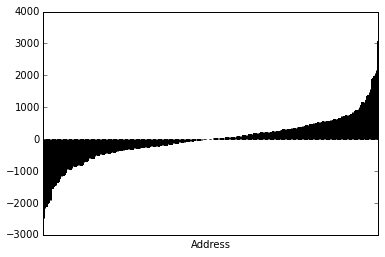

In [308]:
# run the regression based on year_and_area_adj_sqft rather than area_adj_sqft

# create X and y
feature_cols = [data.year_and_area_adj_sqft.name]

X = data[feature_cols]
y = data.Price

# instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
print lm.intercept_
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((lm.predict(X) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(X, y))
zip(feature_cols, lm.coef_)

# calculate predictions for the data set and plot errors
predictions = lm.predict(X)
errors = predictions-y
errors.name = 'Error'

# visualize the relationship between the features and the response using scatterplots
errors.sort()
errors.plot(kind='bar').get_xaxis().set_ticks([])

In [309]:
# add back bedrooms and bathrooms to the regression
# bedrooms and bathrooms are going to be adjusted by the same year and area multipliers as sq ft

factored_beds = data.Bedrooms * data.area_multiplier * data.year_multiplier

factored_beds.name = 'year_and_area_adj_beds'
data = pd.concat([data, factored_beds], axis=1)

data.head()

,Neighborhood,Bedrooms,Bathrooms,Price,Sqft,Date,Source,Year,Neighborhood_Bayview,Neighborhood_Berkeley,...,Year_2011,Year_2012,Year_2013,Year_2014,price_per_foot,area_multiplier,area_adj_sqft,year_multiplier,year_and_area_adj_sqft,year_and_area_adj_beds
Address,,,,,,,,,,,,,,,,,,,,,
539 Octavia Street #9,Hayes Valley,0,1,1500,180,2015-03-18,Climb SF,2015,0,0,...,0,0,0,0,8.333333,1.944004,349.920732,1,349.920732,0
539 Octavia Street #11,Hayes Valley,0,1,1600,200,2015-03-30,Climb SF,2015,0,0,...,0,0,0,0,8.000000,1.944004,388.800813,1,388.800813,0
539 Octavia Street #14,Hayes Valley,0,1,1850,221,2015-05-14,Climb SF,2015,0,0,...,0,0,0,0,8.371041,1.944004,429.624899,1,429.624899,0
539 Octavia Street #12,Hayes Valley,0,1,1800,240,2015-04-16,Climb SF,2015,0,0,...,0,0,0,0,7.500000,1.944004,466.560976,1,466.560976,0
539 Octavia Street #13,Hayes Valley,0,1,1995,280,2015-02-01,Climb SF,2015,0,0,...,0,0,0,0,7.125000,1.944004,544.321139,1,544.321139,0


In [310]:
factored_baths = data.Bathrooms * data.area_multiplier * data.year_multiplier

factored_baths.name = 'year_and_area_adj_baths'
data = pd.concat([data, factored_baths], axis=1)

data.head()

,Neighborhood,Bedrooms,Bathrooms,Price,Sqft,Date,Source,Year,Neighborhood_Bayview,Neighborhood_Berkeley,...,Year_2012,Year_2013,Year_2014,price_per_foot,area_multiplier,area_adj_sqft,year_multiplier,year_and_area_adj_sqft,year_and_area_adj_beds,year_and_area_adj_baths
Address,,,,,,,,,,,,,,,,,,,,,
539 Octavia Street #9,Hayes Valley,0,1,1500,180,2015-03-18,Climb SF,2015,0,0,...,0,0,0,8.333333,1.944004,349.920732,1,349.920732,0,1.944004
539 Octavia Street #11,Hayes Valley,0,1,1600,200,2015-03-30,Climb SF,2015,0,0,...,0,0,0,8.000000,1.944004,388.800813,1,388.800813,0,1.944004
539 Octavia Street #14,Hayes Valley,0,1,1850,221,2015-05-14,Climb SF,2015,0,0,...,0,0,0,8.371041,1.944004,429.624899,1,429.624899,0,1.944004
539 Octavia Street #12,Hayes Valley,0,1,1800,240,2015-04-16,Climb SF,2015,0,0,...,0,0,0,7.500000,1.944004,466.560976,1,466.560976,0,1.944004
539 Octavia Street #13,Hayes Valley,0,1,1995,280,2015-02-01,Climb SF,2015,0,0,...,0,0,0,7.125000,1.944004,544.321139,1,544.321139,0,1.944004


Intercept: 1013.84
Residual sum of squares: 445081.83
Variance score: 0.76
[('year_and_area_adj_sqft', 1.8542471313144895), ('year_and_area_adj_beds', 283.69271933333255), ('year_and_area_adj_baths', 245.58538887304297)]


[]

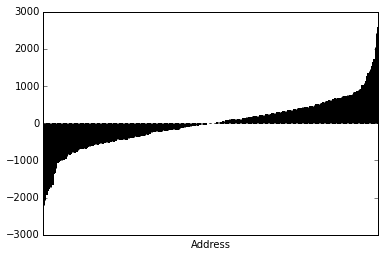

In [311]:
# create X and y
feature_cols = [data.year_and_area_adj_sqft.name, 'year_and_area_adj_beds', 'year_and_area_adj_baths']

X = data[feature_cols]
y = data.Price

# instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
print("Intercept: %.2f" % lm.intercept_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((lm.predict(X) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(X, y))
print zip(feature_cols, lm.coef_)

# calculate predictions for the data set and plot errors
predictions = lm.predict(X)
errors = predictions-y
errors.name = 'Error'

# visualize the relationship between the features and the response using scatterplots
errors.sort()
errors.plot(kind='bar').get_xaxis().set_ticks([])

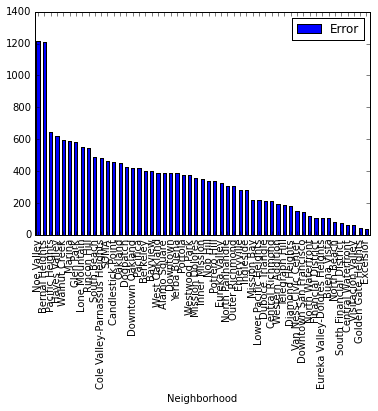

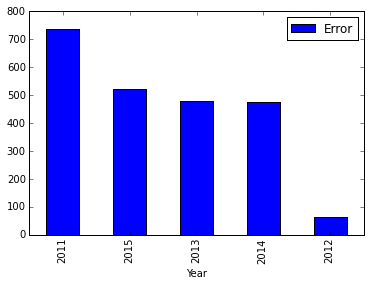

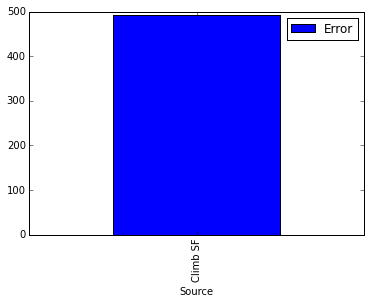

In [312]:
# show errors by neighborhood to see if there are any neighborhoods with funky differences

hooderrors = data[['Neighborhood']]

errors = predictions-y
errors.name = 'Error'

hooderrors = pd.concat([hooderrors,errors.abs()],axis=1)

hood_group = hooderrors.groupby('Neighborhood')

import numpy
def median(lst):
    return numpy.median(numpy.array(lst))

error_avg = hood_group.median()
error_avg.sort(columns='Error',ascending=False).plot(kind='bar')

# show errors by year to see if there are any years with funky differences

yearerrors = data[['Year']]

yearerrors = pd.concat([yearerrors,errors.abs()],axis=1)

year_group = yearerrors.groupby('Year')
error_avg = year_group.mean()
error_avg.sort(columns='Error',ascending=False).plot(kind='bar')

# show errors by source to see if there are any sources have noisy data

srcerrors = data[['Source']]

srcerrors = pd.concat([srcerrors,errors.abs()],axis=1)

src_group = srcerrors.groupby('Source')
error_avg = src_group.mean()
error_avg.sort(columns='Error',ascending=False).plot(kind='bar')


In [313]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
table = ListTable()

dtype = [('Effect', 'S100'), ('Coefficient', float)]

# round to pennies
round_coef = map(round,lm.coef_,[2]*len(lm.coef_))
x = np.array(zip(feature_cols, round_coef),dtype=dtype)
x.T
x = np.sort(x,axis=0,order='Coefficient')

table.append(['Effect','Coefficient'])
for i in x:
    table.append(i)

print "Intercept: $"+`round(lm.intercept_)`
table

Intercept: $1014.0


Effect,Coefficient
year_and_area_adj_sqft,1.85
year_and_area_adj_baths,245.59
year_and_area_adj_beds,283.69


In [314]:
table = ListTable()

dtype = [('Effect', 'S100'), ('Coefficient', float)]

# round to pennies
round_coef = map(round,(area_mults + [1]*len(area_mults)),[2]*len(area_mults))

x = np.array(zip(area_dummies.columns, round_coef),dtype=dtype)
x.T
x = np.sort(x,axis=0,order='Coefficient')

table.append(['Neighborhood','Multiplier'])
for i in x:
    table.append(i)

table

Neighborhood,Multiplier
Neighborhood_Downtown Oakland,0.58
Neighborhood_Visitacion Valley,0.59
Neighborhood_Pacifica,0.73
Neighborhood_Westwood Park,0.74
Neighborhood_West Oakland,0.75
Neighborhood_Walnut Creek,0.79
Neighborhood_Emeryville,0.82
Neighborhood_Glen Park,0.83
Neighborhood_Oakland,0.83
Neighborhood_Portola,0.83
